## Make your own face dataset (Week 12) - Step 3

####**Designed by Joon Son Chung, November 2020**

In this step, we clean the dataset to remove falsely labelled images in the dataset.

Use pre-trained models to flag up the images that are suspicious (likely to contain false labels).

A pre-trained model can be downloaded from [here](http://www.robots.ox.ac.uk/~joon/data/res18_vggface1_pretrained.pt). If you do not have a pre-trained model, you can either:

1.   Filter through the images by hand,
2.   Or train a model without filtering, come back to this step and re-train using the cleaned dataset.

Change the paths in the first box, then `Runtime > Run all`.



In [ ]:
from google.colab import drive
from zipfile import ZipFile
from tqdm import tqdm
import os, glob, sys, shutil, time
import torch
import torchvision.transforms as transforms
import torchvision.models as models
from PIL import Image

# mount Google Drive
drive.mount('/content/drive', force_remount=True)

# path of the data directory relative to the home folder of Google Drive
GDRIVE_HOME = '/content/drive/My Drive'
FOLDER      = 'MLVU/your_dataset'

# The following 4 lines are the only parts of the code that you need to change. You can simply run the rest.
data_dir          = os.path.join(GDRIVE_HOME,FOLDER) 
pretrained_model  = os.path.join(GDRIVE_HOME,'MLVU/res18_vggface1_pretrained.pt')
temp_path         = './cropped_images'

# Set the thresholds for filtering the images
flg_threshold = 0.60 ## flag up to human if similarity is below this number
rem_threshold = 0.40 ## discard without asking if similarity is below this number

# Extract the cropped images
with ZipFile(data_dir+'/cropped_data.zip', 'r') as zipObj:
  zipObj.extractall(temp_path)
print('Zip extraction complete')

First, we define the model, which must be the same as the model trained.

In [ ]:
class FaceRecognition(torch.nn.Module):
	def __init__(self, nEmbed, nClasses):
	    super(FaceRecognition, self).__init__()
	    
	    self.embedding_model 	= models.resnet18(num_classes=nEmbed)
	    self.classifier 		= torch.nn.Linear(nEmbed,nClasses)

	    print('Initialised Softmax Loss')

	def forward(self, x, label=None):

		x 	= self.embedding_model(x)
		out	= self.classifier(x)

		return x, out

Then, define the dataset. 

In [ ]:
class your_dataset(torch.utils.data.Dataset):
	def __init__(self, data_path, transform):

	    self.data   = glob.glob(data_path+'/*/*.jpg')
	    self.transform = transform

	    print('%d files in the dataset'%len(self.data))

	def __getitem__(self, index):

		img = Image.open(self.data[index])
		img = self.transform(img)

		return img, self.data[index]

	def __len__(self):
	  return len(self.data)

Define the data loader. The transforms must be the same as that used to train the model.

In [ ]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.CenterCrop([224,224])])

dataset = your_dataset(temp_path, transform)
loader 	= torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=False, drop_last=True, num_workers=10)

This script allows you to load parameters even if some sizes of some weights have changed.

In [ ]:
def loadParameters(model, path):

    self_state = model.state_dict();
    loaded_state = torch.load(path, map_location="cuda:0");
    for name, param in loaded_state.items():
        origname = name;
        if name not in self_state:

            if name not in self_state:
                print("%s is not in the model."%origname);
                continue;

        if self_state[name].size() != loaded_state[origname].size():
            print("Wrong parameter length: %s, model: %s, loaded: %s"%(origname, self_state[name].size(), loaded_state[origname].size()));
            continue;

        self_state[name].copy_(param);


Load the model.

In [ ]:
model = FaceRecognition(nEmbed=512, nClasses=2700).cuda()
model.eval()

loadParameters(model,pretrained_model)

Extract all embeddings.

In [ ]:
embeddings = {}

for loaded in tqdm(loader):
  data, fname = loaded

  with torch.no_grad():
    embedding, output 	= model(data.cuda())
    embeddings[fname[0]]   = embedding.cpu()
  

Compute the cluster centroids. If the similarity to centroids is less than `rem_threshold`, remove the file without asking. If the similarity is less than `flg_threshold`, flag up for human checking.

Then, the script zips the remaining files.

In [ ]:
files = list(embeddings.keys())
embedding_means = {}

## Concatenate to find embedding means
for file in files:
  identity = file.split('/')[-2]
  if identity not in embedding_means:
    embedding_means[identity] = []
  embedding_means[identity].append(embeddings[file])

## Compute centroids (embedding means) for every identity
identities = embedding_means.keys()
for identity in identities:
  embedding_means[identity] = torch.mean(torch.cat(embedding_means[identity],dim=0),dim=0,keepdim=True)

## Compute distances to centroids
ridx = 0 # number of files removed
fidx = 0 # number of files flagged
files.sort()
for file in files:
  identity = file.split('/')[-2]
  similarity_to_centroid = torch.nn.functional.cosine_similarity(embedding_means[identity],embeddings[file]).cpu().numpy()
  if similarity_to_centroid <= rem_threshold:
    ridx += 1
    os.remove(file)
  elif similarity_to_centroid <= flg_threshold:
    fidx += 1
    print(fidx,file,similarity_to_centroid) 
print(ridx,'files removed,',fidx,'files flagged, out of',len(files),'files')


Save the remaining files to Google Drive. **You do not need to change this section.**

In [ ]:
output_files = glob.glob(temp_path+'/*/*.jpg')

print('%d remaining images found. Now zipping. '%len(output_files))

shutil.make_archive(data_dir+'/cropped_filtered_data', 'zip', root_dir=temp_path)

print('Zipping done')

Having obtained the output, do the following. This does not need to be perfect -- **do not spend more than one hour on this part**.

1.   Download the cropped images `cropped_filtered_data.zip` from Google Drive to your computer.
2.   Visually check the 'suspicious' files in the output above. Delete the incorrectly labeled files.
3.   **Delete any errors that you spot, even if they are not flagged up.**
4.   **If you see many errors (e.g. > 20%) in one folder (e.g. 동명이인이 섞여있는 경우), delete the whole folder.** 
5.   Re-zip and upload to the same folder in Google Drive as a new zip file called `cropped_hand_filtered_data.zip`. Make sure you zip from the directory of the directory with all the identity folders, not the parent directory.

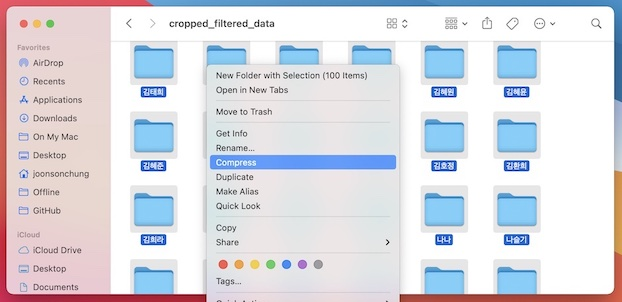